In [2]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split

import tqdm

import itertools
import json
import os

import warnings

In [3]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [6]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.380444,0.180384,-1.712667,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,3.692009,0.254289,-1.369285,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.324900,0.247349,-1.396955,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.128645,0.048493,-3.026331,2650.599402,586308.612876,1718.061157,2650.599402,2650.599402,3.631836,51.036074,160.641345,4.32,583658.013474,1714.429321,2599.563327,2489.958056
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.271124,0.027434,-3.595966,2650.082079,586314.173248,1715.979046,2650.082079,2650.082079,3.704804,51.092926,160.489197,4.32,583664.091169,1712.274243,2598.989153,2489.592882


## TME implementation

### Data loaders

In [7]:
h = 10  # window length
batch_size = 128

# -----------------------------
df = df_merged.sort_values('datetime').reset_index(drop=True)
# STEP 1: Create time-of-day feature
df['time_of_day'] = df['datetime'].dt.strftime('%H:%M')

# -----------------------------
# STEP 2: Split indices (AFTER creating lags!)
n_total = len(df)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)

# -----------------------------
# STEP 3: Create deseasonalizing map using per-time volume means from train only
train_deseason_df = df.iloc[:n_train]
mean_volume_by_time = train_deseason_df.groupby('time_of_day')['total_volume'].mean()
df['mean_volume'] = df['time_of_day'].map(mean_volume_by_time)

df['deseasoned_total_volume'] = df['total_volume'] / df['mean_volume']
df['log_deseasoned_total_volume'] = np.log(df['deseasoned_total_volume'] + 1e-7)
df['target'] = df['deseasoned_total_volume'] + 1e-7

del train_deseason_df

# -----------------------------
# STEP 4: Define the source-specific features
source1_cols = ['buy_volume', 'sell_volume', 'buy_txn', 'sell_txn', 'volume_imbalance', 'txn_imbalance']
source2_cols = ['ask_volume', 'bid_volume', 'ask_slope_1', 'ask_slope_5', 'ask_slope_10', 'bid_slope_1', 'bid_slope_5', 'bid_slope_10', 'spread',
       'lob_volume_imbalance', 'slope_imbalance_1', 'slope_imbalance_5', 'slope_imbalance_10']
# target_col = 'log_deseasoned_total_volume'
target_col = 'target'
datetime_col = 'datetime'


# --- Create rolling windows efficiently ---
source1_array = df[source1_cols].values  # shape (N, F1)
source2_array = df[source2_cols].values  # shape (N, F2)
target_array = df[target_col].values  # shape (N,)
timestamps_array = df[datetime_col].values


# Create sliding windows ([:-1] in windows and [h:] in targets make sure the targets are matched with corresponding features)
source1_windows = sliding_window_view(source1_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F1, h)
source2_windows = sliding_window_view(source2_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F2, h)
y = target_array[h:]
timestamps = timestamps_array[h:]

# Convert to tensors
source1_tensor = torch.tensor(source1_windows, dtype=torch.float32)
source2_tensor = torch.tensor(source2_windows, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# --- Time-based split (preserving time order) ---
n_total = len(y_tensor)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

source1_train, source1_val, source1_test = source1_tensor[:n_train], source1_tensor[n_train:n_train + n_val], source1_tensor[n_train + n_val:]
source2_train, source2_val, source2_test = source2_tensor[:n_train], source2_tensor[n_train:n_train + n_val], source2_tensor[n_train + n_val:]
y_train, y_val, y_test = y_tensor[:n_train], y_tensor[n_train:n_train + n_val], y_tensor[n_train + n_val:]

# (Optional) timestamps split for tracking
timestamps_train = timestamps[:n_train]
timestamps_val = timestamps[n_train:n_train + n_val]
timestamps_test = timestamps[n_train + n_val:]

# Dataset ready for PyTorch training
train_dataset = torch.utils.data.TensorDataset(source1_train, source2_train, y_train)
val_dataset = torch.utils.data.TensorDataset(source1_val, source2_val, y_val)
test_dataset = torch.utils.data.TensorDataset(source1_test, source2_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## function for dataset creation for hyperparams search
def create_datasets(source1_array, source2_array, target_array, batch_size, h):
       # Create sliding windows ([:-1] in windows and [h:] in targets make sure the targets are matched with corresponding features)
       source1_windows = sliding_window_view(source1_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F1, h)
       source2_windows = sliding_window_view(source2_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F2, h)
       y = target_array[h:]

       # Convert to tensors
       source1_tensor = torch.tensor(source1_windows, dtype=torch.float32)
       source2_tensor = torch.tensor(source2_windows, dtype=torch.float32)
       y_tensor = torch.tensor(y, dtype=torch.float32)

       # --- Time-based split (preserving time order) ---
       n_total = len(y_tensor)
       n_train = int(n_total * 0.7)
       n_val = int(n_total * 0.1)

       source1_train, source1_val, source1_test = source1_tensor[:n_train], source1_tensor[n_train:n_train + n_val], source1_tensor[n_train + n_val:]
       source2_train, source2_val, source2_test = source2_tensor[:n_train], source2_tensor[n_train:n_train + n_val], source2_tensor[n_train + n_val:]
       y_train, y_val, y_test = y_tensor[:n_train], y_tensor[n_train:n_train + n_val], y_tensor[n_train + n_val:]

       # Dataset ready for PyTorch training
       train_dataset = torch.utils.data.TensorDataset(source1_train, source2_train, y_train)
       val_dataset = torch.utils.data.TensorDataset(source1_val, source2_val, y_val)
       test_dataset = torch.utils.data.TensorDataset(source1_test, source2_test, y_test)

       train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
       val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
       test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

       return train_loader, val_loader, test_loader


### TME components 

In [97]:
class BilinearRegressor(nn.Module):
    def __init__(self, d, h, latent_variable):
        """
        d: number of features in the source data
        h: number of lags in the source data
        latent_variable (bool): if True the class is devoted for modeling latent variable z, if False => y|s_i
        """
        super().__init__()
        self.latent_variable = latent_variable

        # Mean parameters
        self.L_mu = nn.Parameter(torch.empty(d))
        self.R_mu = nn.Parameter(torch.empty(h))
        self.b_mu = nn.Parameter(torch.zeros(1))

        # Xavier init for 1D weight tensors
        # nn.init.xavier_uniform_(self.L_mu.unsqueeze(0))
        # nn.init.xavier_uniform_(self.R_mu.unsqueeze(0))

        nn.init.xavier_normal_(self.L_mu.unsqueeze(0))
        nn.init.xavier_normal_(self.R_mu.unsqueeze(0))

        if not self.latent_variable:
            self.L_sigma = nn.Parameter(torch.empty(d))
            self.R_sigma = nn.Parameter(torch.empty(h))
            self.b_sigma = nn.Parameter(torch.zeros(1))

            # nn.init.xavier_uniform_(self.L_sigma.unsqueeze(0))
            # nn.init.xavier_uniform_(self.R_sigma.unsqueeze(0))

            nn.init.xavier_normal_(self.L_sigma.unsqueeze(0))
            nn.init.xavier_normal_(self.R_sigma.unsqueeze(0))

    def forward(self, x):  # x: (B, d, h)
        mu = torch.einsum('bdh,d,h->b', x, self.L_mu, self.R_mu) + self.b_mu  # [B]
        if self.latent_variable:
            return mu
        log_var = torch.einsum('bdh,d,h->b', x, self.L_sigma, self.R_sigma) + self.b_sigma
        log_var = torch.clamp(log_var, min=-10, max=10)
        var = torch.exp(log_var)  # Ensure positivity
        return mu, var
    

class TME(nn.Module):
    def __init__(self, d1, d2, h):
        super().__init__()
        self.target1 = BilinearRegressor(d1, h, latent_variable=False)
        self.target2 = BilinearRegressor(d2, h, latent_variable=False)
        self.latent1 = BilinearRegressor(d1, h, latent_variable=True)
        self.latent2 = BilinearRegressor(d2, h, latent_variable=True)

    def forward(self, x1, x2, return_all=False):
        # x1: (B, d1, h), x2: (B, d2, h)
        mu1, var1 = self.target1(x1)  # [B], [B]
        mu2, var2 = self.target2(x2)

        logit1 = self.latent1(x1)
        logit2 = self.latent2(x2)

        logits = torch.stack([logit1, logit2], dim=1)  # [B, num_sources]
        probs = F.softmax(logits, dim=1)     # [B, num_sources]

        if True:#not return_all:
            # Clamp to avoid numerical instability
            mu1 = torch.clamp(mu1, -10, 10)
            mu2 = torch.clamp(mu2, -10, 10)
            var1 = torch.clamp(var1, min=1e-5, max=10)
            var2 = torch.clamp(var2, min=1e-5, max=10)

        # Mixture of expected values under log-normal
        exp1 = torch.exp(mu1 + 0.5 * var1)
        exp2 = torch.exp(mu2 + 0.5 * var2)
        final_pred = probs[:, 0] * exp1 + probs[:, 1] * exp2  # [B]

        if return_all:
            return final_pred, mu1, var1, mu2, var2, probs
        return final_pred


### Training routine

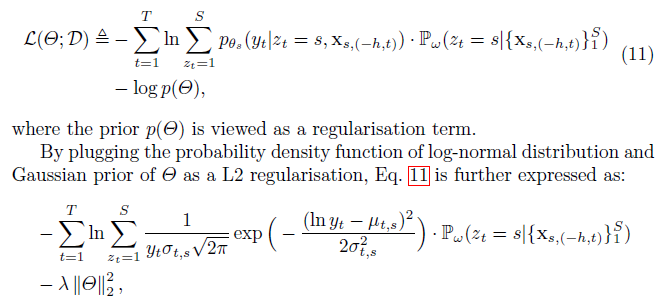

In [98]:
0 % 5

0

In [99]:
def tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=0.1):
    """
    Implements:
        -ln ∑_s [ lognormal(y_t | μ_s, σ_s^2) * P(z_t = s | x) ] + λ * ||θ||^2
    """

    eps = 1e-8  # for numerical stability
    log_y = torch.log(y + eps)

    # Log-normal density terms (not in log-space)
    def lognormal_pdf(y, log_y, mu, var):
        coef = 1.0 / (y * torch.sqrt(2 * torch.pi * var + eps))
        exponent = torch.exp(- (log_y - mu) ** 2 / (2 * var + eps))
        return coef * exponent

    p1 = lognormal_pdf(y, log_y, mu1, var1)
    p2 = lognormal_pdf(y, log_y, mu2, var2)

    # Combine with selector probabilities
    # print(probs[:,1])
    weighted_sum = probs[:,0] * p1 + probs[:,1] * p2

    # Negative log-likelihood (mean over batch)
    nll = -torch.log(weighted_sum + eps).mean() #maybe mean or sum

    # L2 Regularization (Gaussian prior on θ)
    l2_penalty = sum((p**2).sum() for p in model.parameters())
    reg = l2_lambda * l2_penalty

    return nll + reg


def train_tme_model(model, train_loader, val_loader, lr=5e-4, weight_decay=0.1, l2_lambda=0.1,
                    max_epochs=100, patience=10, device='cpu', adam=False):
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, weight_decay=0.1)#, momentum=0.9)
    if adam:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)



    best_val_loss = float('inf')
    best_state_dict = None
    patience_counter = 0
    
    for epoch in range(max_epochs):
        model.train()
        train_losses = []
        y_preds_train = []
        y_true_train = []


        for x1, x2, y in train_loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            optimizer.zero_grad()

            final_pred, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

            loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()

            train_losses.append(loss.item())
            y_preds_train.append(final_pred.detach().cpu())
            y_true_train.append(y.detach().cpu())

        y_preds_train = torch.cat(y_preds_train).numpy()
        y_true_train = torch.cat(y_true_train).numpy()
        rmse_train = np.sqrt(mean_squared_error(y_true_train, y_preds_train))

        # Validation loss
        model.eval()
        val_losses = []
        y_preds_val = []
        y_true_val = []

        with torch.no_grad():
            for x1, x2, y in val_loader:
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)

                final_pred, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

                val_loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
                val_losses.append(val_loss.item())
                y_preds_val.append(final_pred.detach().cpu())
                y_true_val.append(y.detach().cpu())

        avg_val_loss = sum(val_losses) / len(val_losses)
        y_preds_val = torch.cat(y_preds_val).numpy()
        y_true_val = torch.cat(y_true_val).numpy()
        rmse_val = np.sqrt(mean_squared_error(y_true_val, y_preds_val))
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}.      Train Loss: {sum(train_losses)/len(train_losses):.4f}, Val Loss: {avg_val_loss:.4f}.      Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_state_dict)
    return model, best_val_loss


def train_tme_ensemble(train_loader, val_loader, d1, d2, h, num_models=20, device='cpu', adam=False, **train_kwargs):
    ensemble = []
    val_losses = []

    for i in range(num_models):
        print(f"\n🌱 Training ensemble model {i + 1}/{num_models}")

        # Set seed for reproducibility
        torch.manual_seed(i)
        model = TME(d1, d2, h)  # Initialize new model

        # Train the model using your function
        trained_model, best_val_loss = train_tme_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            adam=adam,
            **train_kwargs
        )

        # Save the model and its validation loss
        ensemble.append(trained_model)
        val_losses.append(best_val_loss)

    return ensemble, val_losses



In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=source1_tensor.shape[1],  # number of features of the 1st source
    d2=source2_tensor.shape[1],  # number of features of the 2nd source
    h=source1_tensor.shape[2],  # lag length
    num_models=1,#20,
    device=device,
    lr=5e-5,
    weight_decay=0.1,
    l2_lambda=0.1,
    max_epochs=60,
    patience=10,
    adam=False
)




🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 20.5962, Val Loss: 20.5597.      Train RMSE: 26094.3004, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 20.3187, Val Loss: 20.2868.      Train RMSE: 26094.2893, Val RMSE: 22026.0370
Epoch 10.      Train Loss: 20.0209, Val Loss: 19.9941.      Train RMSE: 26094.2869, Val RMSE: 22026.0370


KeyboardInterrupt: 

In [86]:
np.log(np.max(y_vals))

np.float32(4.4581513)

<Axes: ylabel='Density'>

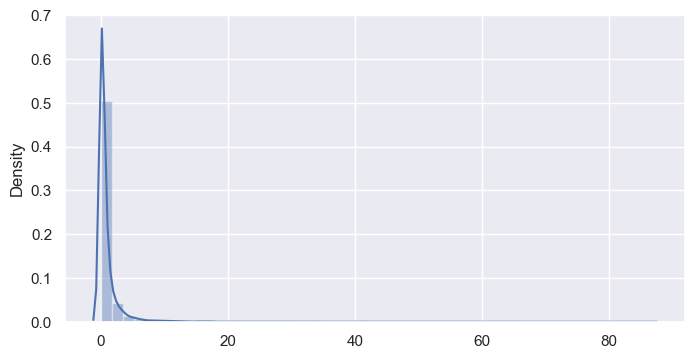

In [84]:
sns.distplot(y_vals)

In [81]:
losses

[1.2496799700817123]

In [115]:
def evaluate_tme_ensemble(ensemble, test_loader, all_preds=False, device='cpu'):
    all_preds = []
    all_preds_median = []
    y_trues = []

    with torch.no_grad():
        for x1, x2, y in test_loader:
            x1, x2, y = x1.to(device).to(torch.float64), x2.to(device).to(torch.float64), y.to(device).to(torch.float64)
            batch_preds = []

            for model in ensemble:
                model.eval()
                model.to(device).to(torch.float64)
                pred = model(x1, x2)
                print(pred)
                return
                batch_preds.append(pred.cpu())

            # Average predictions from all models
            avg_pred = torch.stack(batch_preds).mean(dim=0)
            median_pred = torch.stack(batch_preds).median(dim=0).values
            # avg_pred = torch.stack(batch_preds).median(dim=0)
            all_preds.append(avg_pred)
            all_preds_median.append(median_pred)
            y_trues.append(y.cpu())

    y_preds = torch.cat(all_preds).numpy()
    y_preds_median = torch.cat(all_preds_median).numpy()
    y_trues = torch.cat(y_trues).numpy()

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    mae = mean_absolute_error(y_trues, y_preds)

    # print(f"📊 Ensemble Test RMSE: {rmse:.4f}")
    # print(f"📊 Ensemble Test MAE: {mae:.4f}")
    return y_preds, y_preds_median, rmse, mae


y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')


tensor([ 1.3521,  1.3211,  1.3178,  1.3222,  1.3254,  1.3046,  1.3077,  1.3080,
         1.2940,  1.2928,  1.2996,  1.2921,  1.2883,  1.2883,  1.2999,  1.3254,
         1.3422,  1.3824,  1.3951,  1.4215,  1.3567,  1.3969,  1.3317,  1.2888,
         1.2936,  1.2881,  1.2891,  1.2894,  1.2836,  1.2826,  1.2769,  1.2754,
         1.2757,  1.2637,  1.2650,  1.2649,  1.2700,  1.2666,  1.2639,  1.2663,
         1.2670,  1.2661,  1.2687,  1.2690,  1.2718,  1.2773,  1.2855,  1.2826,
         1.2785,  1.2792,  1.2776,  1.2762,  1.2785,  1.2830,  1.2872,  1.2896,
         1.2855,  1.2836,  1.2875,  1.2791,  1.2727,  1.2686,  1.2696,  1.2669,
         1.2681,  1.2871,  1.2758,  1.2762,  1.2800,  1.2704,  1.2776,  1.3085,
         1.3114,  1.3275,  1.3363,  1.2781,  1.2769,  1.2858,  1.2610,  1.2600,
         1.2673,  1.2840,  1.3105,  1.3159,  1.3189,  1.3206,  1.3142,  1.3120,
         1.3105,  1.3123,  1.3122,  1.3129,  1.3121,  1.3107,  1.3102,  1.3119,
         1.3200,  1.3212,  1.3223,  1.31

TypeError: cannot unpack non-iterable NoneType object

Some things to consider:  
    
    - Model training takes a long time (full 20 model ensemble took me more than 3 hours)  
    - For hyperparams tuning we may use the smaller ensemble  
    - Adam vs SGD?  
    - Now I am clamping the values of the predicted variances and means when training and predicting (to avoid numerical blow up)  
    - The RMSE and MAE I got are reasonable (they are not extremely different). This is just an indication that probably the calculations are doing what they are supposed to do.

In [104]:
y_preds

array([1.35205115, 1.32105566, 1.31779135, ..., 1.27115033, 1.28265187,
       1.3009004 ])

<Axes: ylabel='Density'>

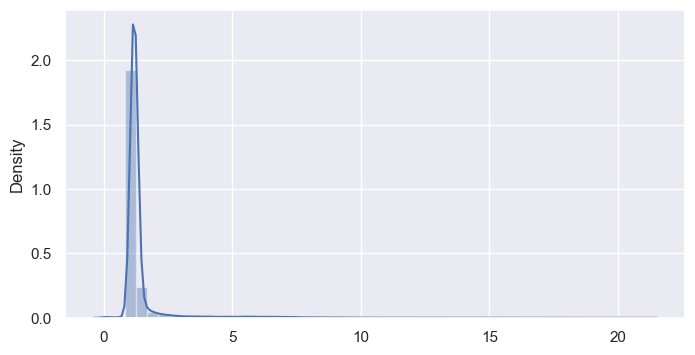

In [38]:
sns.distplot(y_preds)

In [39]:
len(y_preds)

31191

In [105]:
y_preds_final = np.array(y_preds*df.iloc[-len(y_preds):]['mean_volume'])
y_true_final = df.iloc[-len(y_preds):]['total_volume'].values
np.sqrt(mean_squared_error(y_true_final, y_preds_final)), mean_absolute_error(y_true_final, y_preds_final)

(np.float64(22.588381745332175), 10.671468513748367)

### Hyperparams Search

In [15]:
# Directory containing your saved results
input_dir = 'validation_results'
# Make sure the folder exists
os.makedirs(input_dir, exist_ok=True)

# Prepare a list to collect existing files (i.e. corresponding parameters have been already validated)
existing_results = []

# Loop over all files in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(input_dir, filename)
        
        # Open and load the JSON file
        with open(filepath, 'r') as f:
            result = json.load(f)
        
        # Parse hyperparameters from the filename
        name_parts = filename.replace('.json', '').split('_')
        h = int(name_parts[0][1:])  # strip the 'h'
        batch_size = int(name_parts[1][5:])  # strip 'batch'
        lr = float(name_parts[2][2:].replace('e', 'e'))  # scientific notation stays
        l2_lambda = float(name_parts[3][6:])  # strip 'lambda'

        existing_results.append([h,batch_size,lr,l2_lambda])

print(existing_results)

[[10, 128, 0.001, 0.1], [10, 128, 0.001, 1.0], [10, 128, 0.001, 3.0], [10, 128, 0.001, 5.0], [10, 128, 0.0001, 0.1], [10, 128, 0.0001, 1.0], [10, 128, 0.0001, 3.0], [10, 128, 0.0001, 5.0], [10, 128, 0.0005, 0.1], [10, 128, 0.0005, 1.0], [10, 128, 0.0005, 3.0], [10, 128, 0.0005, 5.0], [10, 128, 5e-05, 0.1], [10, 128, 5e-05, 1.0], [10, 128, 5e-05, 3.0], [10, 128, 5e-05, 5.0], [10, 256, 5e-05, 0.1], [10, 64, 0.001, 0.1], [10, 64, 0.001, 1.0], [10, 64, 0.001, 3.0], [10, 64, 0.001, 5.0], [10, 64, 0.0001, 0.1], [10, 64, 0.0001, 1.0], [10, 64, 0.0001, 3.0], [10, 64, 0.0001, 5.0], [10, 64, 0.0005, 0.1], [10, 64, 0.0005, 1.0], [10, 64, 0.0005, 3.0], [10, 64, 0.0005, 5.0], [10, 64, 5e-05, 0.1], [10, 64, 5e-05, 1.0], [10, 64, 5e-05, 3.0], [10, 64, 5e-05, 5.0]]


In [108]:
h_list = [10]#[4, 6, 8, 10]
batch_size_list = [128, 256]
lr_list = [5e-5, 1e-4, 5e-4, 1e-3]
l2_lambda_list = [0.1, 1, 3, 5]

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

# Make sure the folder exists
output_dir = 'validation_results'
os.makedirs(output_dir, exist_ok=True)

for h, batch_size, lr, l2_lambda in tqdm.tqdm(itertools.product(h_list, batch_size_list, lr_list, l2_lambda_list)):
    # if [h, batch_size, lr, l2_lambda] in existing_results:
    #     continue

    # create dataset
    train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_array, batch_size, h)

    print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}")
    
    ensemble, losses = train_tme_ensemble(
        train_loader=train_loader,
        val_loader=val_loader,
        d1=d1,  # number of features of the 1st source
        d2=d2,  # number of features of the 2nd source
        h=h,  # lag length
        num_models=3,#20,
        device=device,
        lr=lr,
        weight_decay=0.1,
        l2_lambda=l2_lambda,
        max_epochs=40,
        patience=5,
        adam=True
    )

    y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, val_loader, device='cpu')

    results_to_save = {
        'rmse': rmse,
        'mae': mae,
        'val_losses': losses
    }

    # Create a filename based on hyperparameters
    filename = f"h{h}_batch{batch_size}_lr{lr:.0e}_lambda{l2_lambda}.json"
    filepath = os.path.join(output_dir, filename)

    # Save the dictionary to a JSON file
    with open(filepath, 'w') as f:
        json.dump(results_to_save, f, indent=4)

0it [00:00, ?it/s]


📊 h: 10, batch_size:128, lr: 5e-05, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 20.4741, Val Loss: 20.3234.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 19.5398, Val Loss: 19.4533.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 8.0754, Val Loss: 8.6831.      Train RMSE: 3268761.9813, Val RMSE: 3268702.1540
Epoch 15.      Train Loss: 3.8504, Val Loss: 0.4545.      Train RMSE: 2041449.2995, Val RMSE: 4.5623
Epoch 20.      Train Loss: 0.7834, Val Loss: 0.0773.      Train RMSE: 8.0529, Val RMSE: 7.4328
Epoch 25.      Train Loss: 0.6777, Val Loss: -0.0251.      Train RMSE: 16.3693, Val RMSE: 9.1773
Epoch 30.      Train Loss: 0.9111, Val Loss: 0.8501.      Train RMSE: 435.0767, Val RMSE: 88.0917
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 20.6137, Val Loss: 20.4584.      Train RMSE: 26094.1177, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 19.6665, Val Loss: 19.580

1it [15:09, 909.90s/it]


📊 h: 10, batch_size:128, lr: 5e-05, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 38.9575, Val Loss: 37.4467.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 29.6138, Val Loss: 28.7583.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 9.0426, Val Loss: 7.3361.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 15.      Train Loss: 4.5675, Val Loss: 2.2142.      Train RMSE: 2.4168, Val RMSE: 2.6712
Epoch 20.      Train Loss: 2.1990, Val Loss: 1.4052.      Train RMSE: 6.3969, Val RMSE: 5.7388
Epoch 25.      Train Loss: 1.4383, Val Loss: 0.7326.      Train RMSE: 4.1630, Val RMSE: 3.8960
Epoch 30.      Train Loss: 1.0375, Val Loss: 0.3995.      Train RMSE: 4.0775, Val RMSE: 3.3441
Epoch 35.      Train Loss: 1.3006, Val Loss: 1.7532.      Train RMSE: 82.3931, Val RMSE: 82.7278
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 40.3564, Val Loss: 38.8113.      Train RMSE: 26094.1177, 

2it [29:47, 890.80s/it]


📊 h: 10, batch_size:128, lr: 5e-05, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 79.9817, Val Loss: 75.3538.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 50.6597, Val Loss: 47.9558.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 16.9729, Val Loss: 14.4516.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 15.      Train Loss: 6.8724, Val Loss: 5.9541.      Train RMSE: 2.4297, Val RMSE: 3.2461
Epoch 20.      Train Loss: 4.6677, Val Loss: 3.7601.      Train RMSE: 3.5739, Val RMSE: 3.4504
Epoch 25.      Train Loss: 2.6226, Val Loss: 1.8189.      Train RMSE: 2.6433, Val RMSE: 2.7878
Epoch 30.      Train Loss: 1.5018, Val Loss: 0.7819.      Train RMSE: 2.5664, Val RMSE: 2.6658
Epoch 35.      Train Loss: 1.7131, Val Loss: 2.5838.      Train RMSE: 78.8393, Val RMSE: 66.1038
Epoch 40.      Train Loss: 0.9840, Val Loss: 0.2277.      Train RMSE: 5.0415, Val RMSE: 3.4207

🌱 Training ensemble model 2/3
Epoch 1.    

3it [45:53, 925.18s/it]


📊 h: 10, batch_size:128, lr: 5e-05, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 121.0226, Val Loss: 113.3092.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 72.1526, Val Loss: 67.6469.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 25.5449, Val Loss: 22.2008.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 15.      Train Loss: 10.5770, Val Loss: 9.4844.      Train RMSE: 2.3433, Val RMSE: 2.6631
Epoch 20.      Train Loss: 6.4414, Val Loss: 5.3036.      Train RMSE: 2.5908, Val RMSE: 2.8522
Epoch 25.      Train Loss: 3.1789, Val Loss: 2.3032.      Train RMSE: 2.2769, Val RMSE: 2.7162
Epoch 30.      Train Loss: 1.6947, Val Loss: 0.9270.      Train RMSE: 2.2821, Val RMSE: 2.6663
Epoch 35.      Train Loss: 1.3178, Val Loss: 0.4925.      Train RMSE: 139.4437, Val RMSE: 7.4997
Epoch 40.      Train Loss: 0.6442, Val Loss: 0.1651.      Train RMSE: 23201.8675, Val RMSE: 6.5423

🌱 Training ensemble model 2/3
Epoch

4it [1:01:42, 934.64s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 20.3312, Val Loss: 20.0594.      Train RMSE: 26094.4046, Val RMSE: 34211.2459
Epoch 5.      Train Loss: 5.8933, Val Loss: 3.3177.      Train RMSE: 1918304.8730, Val RMSE: 2.8935
Epoch 10.      Train Loss: 0.8873, Val Loss: 0.1301.      Train RMSE: 9.4223, Val RMSE: 9.8211
Epoch 15.      Train Loss: 1.1005, Val Loss: 1.1394.      Train RMSE: 9917.9349, Val RMSE: 86.1347
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 20.4679, Val Loss: 20.1902.      Train RMSE: 26094.1177, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 8.2775, Val Loss: 8.8400.      Train RMSE: 3268716.9105, Val RMSE: 3268911.7854
Epoch 10.      Train Loss: 7.7826, Val Loss: 8.4097.      Train RMSE: 3268971.9296, Val RMSE: 3268911.7854
Epoch 15.      Train Loss: 0.8384, Val Loss: 0.1171.      Train RMSE: 8977.8768, Val RMSE: 110.9080
Epoch 20.      Train Loss: 0.7663, Val Loss: 

5it [1:12:28, 830.66s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 37.5285, Val Loss: 34.8130.      Train RMSE: 26094.4046, Val RMSE: 34211.2459
Epoch 5.      Train Loss: 11.0073, Val Loss: 7.6520.      Train RMSE: 1920192.0928, Val RMSE: 2.8935
Epoch 10.      Train Loss: 2.2190, Val Loss: 1.5559.      Train RMSE: 3.9367, Val RMSE: 5.8744
Epoch 15.      Train Loss: 1.2269, Val Loss: 0.5601.      Train RMSE: 3.9868, Val RMSE: 3.5767
Epoch 20.      Train Loss: 0.8773, Val Loss: 0.2032.      Train RMSE: 4.1385, Val RMSE: 3.2526
Epoch 25.      Train Loss: 0.6217, Val Loss: 0.1719.      Train RMSE: 19087.7955, Val RMSE: 9.2141
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 38.8977, Val Loss: 36.1287.      Train RMSE: 26094.1177, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 14.5618, Val Loss: 14.3495.      Train RMSE: 3268627.2481, Val RMSE: 3268911.7854
Epoch 10.      Train Loss: 9.6246, Val Loss: 10.0447.      Tr

6it [1:24:13, 787.77s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 75.5641, Val Loss: 67.0940.      Train RMSE: 26094.4058, Val RMSE: 34211.2459
Epoch 5.      Train Loss: 18.3263, Val Loss: 14.3811.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 10.      Train Loss: 4.6709, Val Loss: 3.8414.      Train RMSE: 3.1255, Val RMSE: 3.3743
Epoch 15.      Train Loss: 1.8985, Val Loss: 1.0491.      Train RMSE: 2.6452, Val RMSE: 2.7763
Epoch 20.      Train Loss: 1.7207, Val Loss: 2.6163.      Train RMSE: 23797.1360, Val RMSE: 61.7839
Epoch 25.      Train Loss: 0.6533, Val Loss: 0.1362.      Train RMSE: 6.4488, Val RMSE: 5.0249
Epoch 30.      Train Loss: 0.6313, Val Loss: 0.2413.      Train RMSE: 10.6658, Val RMSE: 15.0411
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 79.6771, Val Loss: 71.0588.      Train RMSE: 26094.1177, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 26.0024, Val Loss: 24.0363.      Train RMSE: 32684

7it [1:37:29, 790.45s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 113.6600, Val Loss: 99.5434.      Train RMSE: 26094.4058, Val RMSE: 34211.2459
Epoch 5.      Train Loss: 27.8001, Val Loss: 22.0833.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 10.      Train Loss: 7.0899, Val Loss: 5.9070.      Train RMSE: 2.3286, Val RMSE: 3.1504
Epoch 15.      Train Loss: 2.6607, Val Loss: 2.9654.      Train RMSE: 34880.5101, Val RMSE: 2.9881
Epoch 20.      Train Loss: 1.1460, Val Loss: 0.3837.      Train RMSE: 16.3703, Val RMSE: 3.2084
Epoch 25.      Train Loss: 0.6343, Val Loss: 0.1897.      Train RMSE: 20235.0223, Val RMSE: 12.1833
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 120.5151, Val Loss: 106.1518.      Train RMSE: 26094.1177, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 38.2889, Val Loss: 34.5739.      Train RMSE: 3268522.3447, Val RMSE: 3268806.8912
Epoch 10.      Train Loss: 9.9084, Val Loss: 9.7487.     

8it [1:50:04, 779.08s/it]


📊 h: 10, batch_size:128, lr: 0.0005, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 18.1451, Val Loss: 8.7471.      Train RMSE: 1189213.1649, Val RMSE: 3268702.1540
Epoch 5.      Train Loss: 2.6711, Val Loss: 8.2727.      Train RMSE: 1012600.1284, Val RMSE: 3269016.5158
Epoch 10.      Train Loss: 0.8734, Val Loss: 0.6911.      Train RMSE: 2109.0152, Val RMSE: 175.1224
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 19.7071, Val Loss: 19.0656.      Train RMSE: 43076.6833, Val RMSE: 50452.3385
Epoch 5.      Train Loss: 0.8992, Val Loss: 0.7069.      Train RMSE: 1972.4018, Val RMSE: 183.2853
Epoch 10.      Train Loss: 0.8735, Val Loss: 0.6890.      Train RMSE: 2137.7282, Val RMSE: 288.1847
Epoch 15.      Train Loss: 15.3130, Val Loss: 18.4345.      Train RMSE: 95.2885, Val RMSE: 2.8957
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 4.3358, Val Loss: 1.4200.      Train RMSE: 446580.7737, Val RMS

9it [1:56:58, 664.94s/it]


📊 h: 10, batch_size:128, lr: 0.0005, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 28.5678, Val Loss: 13.4145.      Train RMSE: 1189213.1649, Val RMSE: 3268702.1540
Epoch 5.      Train Loss: 5.1929, Val Loss: 8.2296.      Train RMSE: 1845582.8864, Val RMSE: 3269016.5158
Epoch 10.      Train Loss: 4.4053, Val Loss: 8.2274.      Train RMSE: 1156988.8209, Val RMSE: 3269016.5158
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 31.3002, Val Loss: 24.8892.      Train RMSE: 43076.6833, Val RMSE: 50452.3538
Epoch 5.      Train Loss: 2.9682, Val Loss: 1.8299.      Train RMSE: 1462.0028, Val RMSE: 95.7392
Epoch 10.      Train Loss: 1.2949, Val Loss: 1.6623.      Train RMSE: 111997.1337, Val RMSE: 91.0282
Epoch 15.      Train Loss: 1.2702, Val Loss: 1.6653.      Train RMSE: 94.1463, Val RMSE: 91.6820
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 11.5182, Val Loss: 3.8858.      Train RMSE: 370164.5697, V

10it [2:02:44, 566.63s/it]


📊 h: 10, batch_size:128, lr: 0.0005, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 48.2216, Val Loss: 19.6573.      Train RMSE: 1689584.2520, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 1.4805, Val Loss: 0.3671.      Train RMSE: 61.9177, Val RMSE: 20.1750
Epoch 10.      Train Loss: 1.2650, Val Loss: 0.5001.      Train RMSE: 61.4609, Val RMSE: 4.0533
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 54.0513, Val Loss: 23.9762.      Train RMSE: 1062214.5535, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 3.6243, Val Loss: 2.5628.      Train RMSE: 1067230.3799, Val RMSE: 92.8062
Epoch 10.      Train Loss: 1.2379, Val Loss: 2.5705.      Train RMSE: 10881.4014, Val RMSE: 76.8681
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 26.4982, Val Loss: 6.7473.      Train RMSE: 364394.8347, Val RMSE: 5016.3184
Epoch 5.      Train Loss: 1.2403, Val Loss: 0.3517.      Train RMSE: 7483.4781, Val RMSE: 11.

11it [2:07:20, 477.63s/it]


📊 h: 10, batch_size:128, lr: 0.0005, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 69.4056, Val Loss: 21.8947.      Train RMSE: 983910.9808, Val RMSE: 2.8935
Epoch 5.      Train Loss: 2.1835, Val Loss: 0.7747.      Train RMSE: 85065.5435, Val RMSE: 8.1210
Epoch 10.      Train Loss: 1.3779, Val Loss: 0.3333.      Train RMSE: 78625.4229, Val RMSE: 4.3932
Epoch 15.      Train Loss: 1.1274, Val Loss: 0.3247.      Train RMSE: 2.6744, Val RMSE: 2.7252
Epoch 20.      Train Loss: 1.3403, Val Loss: 0.7238.      Train RMSE: 14920.6461, Val RMSE: 53.1775
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 78.5315, Val Loss: 34.4751.      Train RMSE: 1079675.0150, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 2.3748, Val Loss: 1.3696.      Train RMSE: 81041.5400, Val RMSE: 33.2013
Epoch 10.      Train Loss: 1.5460, Val Loss: 0.4551.      Train RMSE: 62542.4180, Val RMSE: 19.5862
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch

12it [2:13:02, 436.53s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 11.2998, Val Loss: 2.9523.      Train RMSE: 982029.3471, Val RMSE: 2.8935
Epoch 5.      Train Loss: 5.3852, Val Loss: 0.7172.      Train RMSE: 2670189.1230, Val RMSE: 140.1011
Epoch 10.      Train Loss: 4.1015, Val Loss: 2.8272.      Train RMSE: 2.4800, Val RMSE: 2.8935
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 14.1802, Val Loss: 8.4634.      Train RMSE: 2238072.1194, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 8.0757, Val Loss: 18.4469.      Train RMSE: 2047.5728, Val RMSE: 2.8957
Epoch 10.      Train Loss: 4.8503, Val Loss: 18.4540.      Train RMSE: 2343.0314, Val RMSE: 2.8957
Epoch 15.      Train Loss: 8.9969, Val Loss: 18.4360.      Train RMSE: 4651.8022, Val RMSE: 2.8957
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 3.6904, Val Loss: 8.4187.      Train RMSE: 1200741.4678, Val RMSE: 3268911.785

13it [2:19:20, 418.68s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 17.7636, Val Loss: 4.0910.      Train RMSE: 982029.3471, Val RMSE: 2.8935
Epoch 5.      Train Loss: 4.8073, Val Loss: 8.4774.      Train RMSE: 280632.6074, Val RMSE: 3269016.5158
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 21.7657, Val Loss: 10.5601.      Train RMSE: 2238364.9237, Val RMSE: 3269016.5158
Epoch 5.      Train Loss: 3.6940, Val Loss: 1.6534.      Train RMSE: 121.4604, Val RMSE: 92.0319
Epoch 10.      Train Loss: 2.9036, Val Loss: 1.6761.      Train RMSE: 1266384.5716, Val RMSE: 113.0471
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 7.9788, Val Loss: 8.6373.      Train RMSE: 1294057.1345, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 2.7500, Val Loss: 1.7085.      Train RMSE: 316532.5611, Val RMSE: 104.3951
Early stopping triggered.


14it [2:23:04, 359.79s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 27.8356, Val Loss: 4.2710.      Train RMSE: 671408.5016, Val RMSE: 9.9493
Epoch 5.      Train Loss: 4.5689, Val Loss: 2.4474.      Train RMSE: 1694827.8105, Val RMSE: 92.0126
Epoch 10.      Train Loss: 4.6485, Val Loss: 8.2627.      Train RMSE: 2078598.4280, Val RMSE: 3269016.5158
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 32.8839, Val Loss: 6.5606.      Train RMSE: 2295649.8500, Val RMSE: 43.3798
Epoch 5.      Train Loss: 3.8095, Val Loss: 3.3359.      Train RMSE: 1450053.8288, Val RMSE: 26.6484
Epoch 10.      Train Loss: 3.7503, Val Loss: 2.5630.      Train RMSE: 1576729.7494, Val RMSE: 84.1035
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 14.8765, Val Loss: 3.4595.      Train RMSE: 251289.7552, Val RMSE: 2.8935
Epoch 5.      Train Loss: 2.5626, Val Loss: 2.4903.      Train RMSE: 236.6699, Val RMSE: 90.2

15it [2:27:31, 331.90s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 39.9619, Val Loss: 4.4807.      Train RMSE: 671408.5016, Val RMSE: 7.2145
Epoch 5.      Train Loss: 3.0489, Val Loss: 3.1129.      Train RMSE: 244273.4876, Val RMSE: 52.4092
Epoch 10.      Train Loss: 2.4408, Val Loss: 0.3367.      Train RMSE: 868073.9555, Val RMSE: 2.7645
Epoch 15.      Train Loss: 4.4052, Val Loss: 0.6314.      Train RMSE: 1648842.5615, Val RMSE: 2.8126
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 47.8367, Val Loss: 8.8067.      Train RMSE: 2295645.0540, Val RMSE: 38.4418
Epoch 5.      Train Loss: 3.1012, Val Loss: 2.9433.      Train RMSE: 826516.7648, Val RMSE: 2.8935
Epoch 10.      Train Loss: 3.9827, Val Loss: 3.0852.      Train RMSE: 1446720.6668, Val RMSE: 50.7981
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 23.6209, Val Loss: 3.4937.      Train RMSE: 1142643.3175, Val RMSE: 2.8935
E

16it [2:32:39, 324.68s/it]


📊 h: 10, batch_size:256, lr: 5e-05, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 20.5515, Val Loss: 20.4719.      Train RMSE: 26094.3053, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 19.9976, Val Loss: 19.9385.      Train RMSE: 26094.3960, Val RMSE: 34211.2459
Epoch 10.      Train Loss: 19.4951, Val Loss: 19.4523.      Train RMSE: 27907.1191, Val RMSE: 43077.5182
Epoch 15.      Train Loss: 11.5864, Val Loss: 3.5212.      Train RMSE: 1894503.1583, Val RMSE: 2.8935
Epoch 20.      Train Loss: 4.5901, Val Loss: 3.2838.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 25.      Train Loss: 4.4173, Val Loss: 3.1153.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 30.      Train Loss: 1.2162, Val Loss: 0.3710.      Train RMSE: 2.9876, Val RMSE: 4.5261
Epoch 35.      Train Loss: 0.8790, Val Loss: 0.1486.      Train RMSE: 11.3955, Val RMSE: 11.3971
Epoch 40.      Train Loss: 0.7632, Val Loss: 0.0480.      Train RMSE: 8.0519, Val RMSE: 7.7842

🌱 Training ensemble model

17it [2:43:29, 422.44s/it]


📊 h: 10, batch_size:256, lr: 5e-05, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 39.7323, Val Loss: 38.9324.      Train RMSE: 26094.3053, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 34.1924, Val Loss: 33.6041.      Train RMSE: 26094.3985, Val RMSE: 34211.2459
Epoch 10.      Train Loss: 29.1679, Val Loss: 28.7487.      Train RMSE: 27907.1191, Val RMSE: 43077.5182
Epoch 15.      Train Loss: 18.0672, Val Loss: 9.7276.      Train RMSE: 1905760.0148, Val RMSE: 2.8935
Epoch 20.      Train Loss: 8.8120, Val Loss: 7.3211.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 25.      Train Loss: 7.1053, Val Loss: 5.6773.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 30.      Train Loss: 3.0054, Val Loss: 2.2618.      Train RMSE: 2.3733, Val RMSE: 3.2071
Epoch 35.      Train Loss: 2.5817, Val Loss: 1.8373.      Train RMSE: 6.3240, Val RMSE: 6.6763
Epoch 40.      Train Loss: 2.1229, Val Loss: 1.3945.      Train RMSE: 5.9946, Val RMSE: 5.7821

🌱 Training ensemble model 2/3

18it [2:53:58, 484.70s/it]


📊 h: 10, batch_size:256, lr: 5e-05, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 82.3434, Val Loss: 79.9167.      Train RMSE: 26094.3053, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 65.1761, Val Loss: 63.3185.      Train RMSE: 26094.3985, Val RMSE: 34211.2459
Epoch 10.      Train Loss: 49.2479, Val Loss: 47.9257.      Train RMSE: 27907.1191, Val RMSE: 43077.5182
Epoch 15.      Train Loss: 23.8274, Val Loss: 21.6348.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 20.      Train Loss: 16.3059, Val Loss: 14.4191.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 25.      Train Loss: 11.4001, Val Loss: 9.7411.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 30.      Train Loss: 6.8132, Val Loss: 5.9548.      Train RMSE: 2.5790, Val RMSE: 3.4733
Epoch 35.      Train Loss: 5.8093, Val Loss: 4.9704.      Train RMSE: 3.4970, Val RMSE: 3.4992
Epoch 40.      Train Loss: 4.4768, Val Loss: 3.6903.      Train RMSE: 3.4915, Val RMSE: 3.4630

🌱 Training ensemble model 2/3
E

19it [3:04:23, 526.78s/it]


📊 h: 10, batch_size:256, lr: 5e-05, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 124.9587, Val Loss: 120.9140.      Train RMSE: 26094.3053, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 96.3467, Val Loss: 93.2508.      Train RMSE: 26094.3985, Val RMSE: 34211.2459
Epoch 10.      Train Loss: 69.7996, Val Loss: 67.5967.      Train RMSE: 27907.1191, Val RMSE: 43077.5182
Epoch 15.      Train Loss: 36.9676, Val Loss: 34.1713.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 20.      Train Loss: 24.4333, Val Loss: 22.1469.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 25.      Train Loss: 16.2095, Val Loss: 14.2715.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 30.      Train Loss: 10.6029, Val Loss: 9.6955.      Train RMSE: 2.3520, Val RMSE: 2.6784
Epoch 35.      Train Loss: 9.0273, Val Loss: 8.0676.      Train RMSE: 2.5149, Val RMSE: 3.1340
Epoch 40.      Train Loss: 7.0207, Val Loss: 6.1168.      Train RMSE: 2.6930, Val RMSE: 3.0372

🌱 Training ensemble model 2

20it [3:14:47, 555.88s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 20.4740, Val Loss: 20.3230.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 19.5510, Val Loss: 19.4671.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 8.1059, Val Loss: 8.7145.      Train RMSE: 3268702.3144, Val RMSE: 3268597.2531
Epoch 15.      Train Loss: 7.8039, Val Loss: 8.4325.      Train RMSE: 3268926.7013, Val RMSE: 3268911.7854
Epoch 20.      Train Loss: 1.0881, Val Loss: 1.2638.      Train RMSE: 17137.3996, Val RMSE: 79.3855
Epoch 25.      Train Loss: 0.7963, Val Loss: 0.0922.      Train RMSE: 78.9491, Val RMSE: 85.7032
Epoch 30.      Train Loss: 0.7557, Val Loss: 0.0612.      Train RMSE: 142.6283, Val RMSE: 88.1427
Epoch 35.      Train Loss: 0.7257, Val Loss: -0.0085.      Train RMSE: 969.3569, Val RMSE: 64.4690
Epoch 40.      Train Loss: 0.6151, Val Loss: -0.0727.      Train RMSE: 22336.7371, Val RMSE: 177.4496

21it [3:25:10, 576.13s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 38.9569, Val Loss: 37.4437.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 29.7270, Val Loss: 28.8966.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 12.8008, Val Loss: 13.0383.      Train RMSE: 3268866.8770, Val RMSE: 3268806.8912
Epoch 15.      Train Loss: 6.3414, Val Loss: 4.8534.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 20.      Train Loss: 2.1606, Val Loss: 1.3952.      Train RMSE: 4.4286, Val RMSE: 5.5679
Epoch 25.      Train Loss: 1.7247, Val Loss: 0.9727.      Train RMSE: 5.0741, Val RMSE: 4.6469
Epoch 30.      Train Loss: 1.2720, Val Loss: 0.5490.      Train RMSE: 4.0380, Val RMSE: 3.4845
Epoch 35.      Train Loss: 0.9748, Val Loss: 0.2911.      Train RMSE: 3.8131, Val RMSE: 3.2345
Epoch 40.      Train Loss: 0.8675, Val Loss: 0.2202.      Train RMSE: 3.9682, Val RMSE: 3.3968

🌱 Training ensemble model 2/3
E

22it [3:35:34, 590.57s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 79.9811, Val Loss: 75.3436.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 50.6816, Val Loss: 47.9766.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 20.3473, Val Loss: 19.7419.      Train RMSE: 3268941.4567, Val RMSE: 3268911.7854
Epoch 15.      Train Loss: 7.4278, Val Loss: 4.6448.      Train RMSE: 2.4131, Val RMSE: 2.7413
Epoch 20.      Train Loss: 4.7448, Val Loss: 3.8874.      Train RMSE: 3.0462, Val RMSE: 3.1380
Epoch 25.      Train Loss: 3.4573, Val Loss: 2.6856.      Train RMSE: 3.0507, Val RMSE: 3.0428
Epoch 30.      Train Loss: 2.1387, Val Loss: 1.3640.      Train RMSE: 2.6587, Val RMSE: 2.7291
Epoch 35.      Train Loss: 1.3728, Val Loss: 0.6312.      Train RMSE: 2.5554, Val RMSE: 2.6049
Epoch 40.      Train Loss: 1.1031, Val Loss: 0.4269.      Train RMSE: 41.2418, Val RMSE: 14.5924

🌱 Training ensemble model 2/3

23it [3:45:57, 600.18s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 121.0217, Val Loss: 113.2923.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 72.1891, Val Loss: 67.6815.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 28.8600, Val Loss: 27.4187.      Train RMSE: 3268941.4567, Val RMSE: 3268911.7854
Epoch 15.      Train Loss: 9.1551, Val Loss: 7.6201.      Train RMSE: 2.3411, Val RMSE: 2.7262
Epoch 20.      Train Loss: 6.8674, Val Loss: 5.8681.      Train RMSE: 2.4647, Val RMSE: 2.9873
Epoch 25.      Train Loss: 4.4467, Val Loss: 3.4912.      Train RMSE: 2.4421, Val RMSE: 2.7303
Epoch 30.      Train Loss: 2.4630, Val Loss: 1.6144.      Train RMSE: 2.2669, Val RMSE: 2.6816
Epoch 35.      Train Loss: 1.4153, Val Loss: 0.6523.      Train RMSE: 2.2852, Val RMSE: 2.6395
Epoch 40.      Train Loss: 1.0882, Val Loss: 0.4232.      Train RMSE: 3.9655, Val RMSE: 2.9365

🌱 Training ensemble model 2/3

24it [3:56:17, 606.24s/it]


📊 h: 10, batch_size:256, lr: 0.0005, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 19.9798, Val Loss: 19.4759.      Train RMSE: 26094.4144, Val RMSE: 43077.5182
Epoch 5.      Train Loss: 6.2590, Val Loss: 1.4795.      Train RMSE: 2868918.2509, Val RMSE: 79.6319
Epoch 10.      Train Loss: 0.8742, Val Loss: 0.7018.      Train RMSE: 2624.1173, Val RMSE: 198.3102
Epoch 15.      Train Loss: 0.8786, Val Loss: 0.7101.      Train RMSE: 2127.0651, Val RMSE: 154.6374
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 20.1113, Val Loss: 19.6031.      Train RMSE: 27906.9620, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 7.7564, Val Loss: 8.3661.      Train RMSE: 3269001.4400, Val RMSE: 3269016.5158
Epoch 10.      Train Loss: 4.1732, Val Loss: 2.8661.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 15.      Train Loss: 0.8747, Val Loss: 0.6913.      Train RMSE: 2338.0400, Val RMSE: 174.3799
Epoch 20.      Train Loss: 4.1188, Val Loss: 2.827

25it [4:01:07, 511.33s/it]


📊 h: 10, batch_size:256, lr: 0.0005, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 34.0142, Val Loss: 28.9842.      Train RMSE: 26094.4144, Val RMSE: 43077.5182
Epoch 5.      Train Loss: 4.9012, Val Loss: 3.3670.      Train RMSE: 2.4787, Val RMSE: 2.8935
Epoch 10.      Train Loss: 3.9843, Val Loss: 2.8267.      Train RMSE: 2.4740, Val RMSE: 2.8935
Epoch 15.      Train Loss: 0.8733, Val Loss: 0.1944.      Train RMSE: 3.7309, Val RMSE: 3.1693
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 35.3320, Val Loss: 30.2576.      Train RMSE: 27906.9620, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 9.3668, Val Loss: 9.6190.      Train RMSE: 3268941.4567, Val RMSE: 3269016.5158
Epoch 10.      Train Loss: 4.2988, Val Loss: 2.9573.      Train RMSE: 1364.3707, Val RMSE: 2.8935
Epoch 15.      Train Loss: 1.3072, Val Loss: 1.6524.      Train RMSE: 93.7153, Val RMSE: 91.2174
Epoch 20.      Train Loss: 1.2701, Val Loss: 1.6686.      Train RMSE:

26it [4:06:48, 460.03s/it]


📊 h: 10, batch_size:256, lr: 0.0005, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 64.3867, Val Loss: 47.9938.      Train RMSE: 26094.4144, Val RMSE: 43077.5182
Epoch 5.      Train Loss: 5.2402, Val Loss: 8.6800.      Train RMSE: 968319.6870, Val RMSE: 3269016.5158
Epoch 10.      Train Loss: 3.5130, Val Loss: 2.6459.      Train RMSE: 1114671.5066, Val RMSE: 61.5880
Epoch 15.      Train Loss: 1.0391, Val Loss: 0.3751.      Train RMSE: 43.6382, Val RMSE: 3.2523
Epoch 20.      Train Loss: 1.0169, Val Loss: 0.2789.      Train RMSE: 2.7924, Val RMSE: 2.5908
Epoch 25.      Train Loss: 1.0898, Val Loss: 0.3007.      Train RMSE: 19704.9379, Val RMSE: 3.0653
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 68.3842, Val Loss: 51.9662.      Train RMSE: 27906.9620, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 4.5911, Val Loss: 4.5475.      Train RMSE: 73.9787, Val RMSE: 87.3597
Epoch 10.      Train Loss: 4.4708, Val Loss: 2.8974.      Tra

27it [4:13:23, 440.51s/it]


📊 h: 10, batch_size:256, lr: 0.0005, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 95.0309, Val Loss: 67.7102.      Train RMSE: 26094.4144, Val RMSE: 43077.5182
Epoch 5.      Train Loss: 3.4121, Val Loss: 1.2549.      Train RMSE: 2.3839, Val RMSE: 2.7564
Epoch 10.      Train Loss: 1.4752, Val Loss: 3.2518.      Train RMSE: 35480.3382, Val RMSE: 23.2947
Epoch 15.      Train Loss: 1.4523, Val Loss: 0.6636.      Train RMSE: 50.2149, Val RMSE: 9.1291
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 101.6935, Val Loss: 74.3308.      Train RMSE: 27906.9620, Val RMSE: 50407.6667
Epoch 5.      Train Loss: 5.9017, Val Loss: 5.4843.      Train RMSE: 74.8741, Val RMSE: 84.5264
Epoch 10.      Train Loss: 1.3026, Val Loss: 0.7067.      Train RMSE: 9894.3220, Val RMSE: 11.8331
Epoch 15.      Train Loss: 1.4667, Val Loss: 0.7517.      Train RMSE: 56.5226, Val RMSE: 97.9447
Epoch 20.      Train Loss: 0.8497, Val Loss: 0.3717.      Train RMSE: 9

28it [4:19:18, 415.06s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:0.1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 18.0557, Val Loss: 8.7518.      Train RMSE: 1220574.0129, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 0.8767, Val Loss: 0.6921.      Train RMSE: 1246.9129, Val RMSE: 207.6266
Epoch 10.      Train Loss: 12.7424, Val Loss: 18.4388.      Train RMSE: 899.4631, Val RMSE: 2.8957
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 19.3504, Val Loss: 8.8763.      Train RMSE: 579723.1211, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 0.9125, Val Loss: 0.7079.      Train RMSE: 1386.8261, Val RMSE: 161.1082
Epoch 10.      Train Loss: 2.8032, Val Loss: 0.7096.      Train RMSE: 7506.6672, Val RMSE: 259.3601
Epoch 15.      Train Loss: 0.8737, Val Loss: 0.6854.      Train RMSE: 3303.1532, Val RMSE: 213.0019
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 4.1978, Val Loss: 1.3361.      Train RMSE: 407787.9116, Val RMSE: 17

29it [4:23:48, 371.38s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:1

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 28.4568, Val Loss: 13.4238.      Train RMSE: 1220493.7933, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 2.6527, Val Loss: 2.8591.      Train RMSE: 65.6594, Val RMSE: 2.8935
Epoch 10.      Train Loss: 2.8801, Val Loss: 1.6491.      Train RMSE: 1598662.0966, Val RMSE: 91.2854
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 30.9180, Val Loss: 14.7048.      Train RMSE: 581390.1469, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 1.4996, Val Loss: 1.7522.      Train RMSE: 93.9995, Val RMSE: 90.7861
Epoch 10.      Train Loss: 1.2723, Val Loss: 1.6632.      Train RMSE: 94.2044, Val RMSE: 91.1758
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 11.3439, Val Loss: 3.7963.      Train RMSE: 349428.0672, Val RMSE: 69060.8302
Epoch 5.      Train Loss: 4.3058, Val Loss: 8.2380.      Train RMSE: 1090071.3873, Val RMSE: 3269

30it [4:26:59, 317.43s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:3

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 48.1347, Val Loss: 19.6122.      Train RMSE: 1708052.4123, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 3.3058, Val Loss: 2.6076.      Train RMSE: 895569.3045, Val RMSE: 63.2555
Epoch 10.      Train Loss: 2.9026, Val Loss: 3.2967.      Train RMSE: 962856.9414, Val RMSE: 26.5039
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 53.2769, Val Loss: 23.9481.      Train RMSE: 1366338.2648, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 1.9803, Val Loss: 2.5503.      Train RMSE: 111.0956, Val RMSE: 92.2116
Epoch 10.      Train Loss: 3.7815, Val Loss: 8.2610.      Train RMSE: 1757894.5696, Val RMSE: 3269016.5158
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 26.3564, Val Loss: 6.6092.      Train RMSE: 358308.0911, Val RMSE: 2983.6498
Epoch 5.      Train Loss: 3.2040, Val Loss: 2.5365.      Train RMSE: 838379.9888, 

31it [4:29:34, 268.70s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:5

🌱 Training ensemble model 1/3
Epoch 1.      Train Loss: 69.9242, Val Loss: 27.1991.      Train RMSE: 1708052.4123, Val RMSE: 3268806.8912
Epoch 5.      Train Loss: 4.3036, Val Loss: 3.2962.      Train RMSE: 1678109.3489, Val RMSE: 23.9851
Early stopping triggered.

🌱 Training ensemble model 2/3
Epoch 1.      Train Loss: 77.7860, Val Loss: 34.4278.      Train RMSE: 1366338.2648, Val RMSE: 3268911.7854
Epoch 5.      Train Loss: 3.8475, Val Loss: 2.9186.      Train RMSE: 31867.4786, Val RMSE: 2.8935
Epoch 10.      Train Loss: 3.6089, Val Loss: 8.2310.      Train RMSE: 1380362.9198, Val RMSE: 3269015.5535
Early stopping triggered.

🌱 Training ensemble model 3/3
Epoch 1.      Train Loss: 41.6758, Val Loss: 10.0228.      Train RMSE: 369984.1273, Val RMSE: 2108.1152
Epoch 5.      Train Loss: 5.2242, Val Loss: 2.8272.      Train RMSE: 2202032.7761, Val RMSE: 2.8935
Epoch 10.      Train Loss: 4.0033, Val Loss: 0.3796.      Train RMSE: 1515208.78

32it [4:32:48, 511.51s/it]


In [109]:
# Directory containing your saved results
input_dir = 'validation_results'

# Prepare a list to collect all results
all_results = []
existing_results = []

# Loop over all files in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(input_dir, filename)
        
        # Open and load the JSON file
        with open(filepath, 'r') as f:
            result = json.load(f)
        
        # Parse hyperparameters from the filename
        name_parts = filename.replace('.json', '').split('_')
        h = int(name_parts[0][1:])  # strip the 'h'
        batch_size = int(name_parts[1][5:])  # strip 'batch'
        lr = float(name_parts[2][2:].replace('e', 'e'))  # scientific notation stays
        l2_lambda = float(name_parts[3][6:])  # strip 'lambda'

        existing_results.append([h,batch_size,lr,l2_lambda])
        
        # Combine hyperparameters and results
        entry = {
            'h': h,
            'batch_size': batch_size,
            'lr': lr,
            'l2_lambda': l2_lambda,
            **result  # unpack the RMSE, MAE, etc.
        }
        all_results.append(entry)

# Now `all_results` is a list of dictionaries
print(all_results)

[{'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 0.1, 'rmse': 1089726.1613200568, 'mae': 1089726.1569289148, 'val_losses': [0.7013087279972483, 0.6707661559225105, 0.6705304299343805]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 1.0, 'rmse': 36.60138394557098, 'mae': 32.128989496778956, 'val_losses': [1.6637232920429745, 1.6190716325015317, 1.6649700327486288]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 3.0, 'rmse': 2179361.534267373, 'mae': 2179361.5341919395, 'val_losses': [2.4473783847738484, 2.534669772279067, 2.48196539331655]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 5.0, 'rmse': 2179344.5025853366, 'mae': 2179344.502583613, 'val_losses': [0.33665505479105184, 0.5487079876856725, 2.8285509947778995]}, {'h': 10, 'batch_size': 128, 'lr': 0.0001, 'l2_lambda': 0.1, 'rmse': 34.380482429447696, 'mae': 26.47390019265506, 'val_losses': [0.004263333976268768, -0.0775618064598959, -0.07598065337563148]}, {'h': 10, 'batch_size': 128, 'lr': 0.00

In [110]:
pd.DataFrame(all_results).sort_values("rmse")

,h,batch_size,lr,l2_lambda,rmse,mae,val_losses
21,10,256,0.00010,1.0,4.960036e+00,3.049843e+00,"[0.20360519089659707, 0.4889580885894963, 0.07..."
23,10,256,0.00010,5.0,5.890159e+00,5.592879e+00,"[0.37920478059620155, 1.5507688375770068, 0.12..."
22,10,256,0.00010,3.0,7.148934e+00,5.511608e+00,"[0.4268751119981047, 1.0671539570464463, 0.128..."
14,10,128,0.00005,3.0,8.556378e+00,8.372315e+00,"[0.22772850590895433, 1.0314949960982214, 0.16..."
6,10,128,0.00010,3.0,9.096391e+00,8.914076e+00,"[0.12600167077721752, 0.13637380509591493, 0.0..."
15,10,128,0.00005,5.0,9.364026e+00,9.188426e+00,"[0.165138700091448, 1.4280872393826969, 0.1347..."
7,10,128,0.00010,5.0,1.184671e+01,1.171041e+01,"[0.08561097016771797, 0.11317839338367836, 0.0..."
11,10,128,0.00050,5.0,1.883541e+01,9.728747e+00,"[0.32468328185257367, 0.34151489464718787, 0.3..."
29,10,256,0.00005,1.0,1.957012e+01,1.635112e+01,"[1.3945028410583247, 4.229291532860428, 0.6333..."
5,10,128,0.00010,1.0,1.964133e+01,1.582195e+01,"[0.08398216113936706, 0.09961788298287352, 0.1..."


In [ ]:
h_list = [10]#[4, 6, 8, 10]
batch_size_list = [64, 128, 256]
lr_list = [5e-5, 1e-4, 5e-4, 1e-3]
l2_lambda_list = [0.1, 1, 3, 5]

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

# Make sure the folder exists
output_dir = 'validation_results'
os.makedirs(output_dir, exist_ok=True)

# printing such hyperparams combination that are not already processed
for h, batch_size, lr, l2_lambda in tqdm.tqdm(itertools.product(h_list, batch_size_list, lr_list, l2_lambda_list)):
    if [h, batch_size, lr, l2_lambda] in existing_results:
        continue
    
    print(h, batch_size, lr, l2_lambda)

48it [00:00, ?it/s]


## Training final model

In [111]:
h, batch_size, lr, l2_lambda = 10, 256, 1e-4, 1

train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_array, batch_size, h)

print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}")

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=d1,  # number of features of the 1st source
    d2=d2,  # number of features of the 2nd source
    h=h,  # lag length
    num_models=20,#20,
    device=device,
    lr=lr,
    weight_decay=0.1,
    l2_lambda=l2_lambda,
    max_epochs=100,
    patience=10,
    adam=True
)

y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:1

🌱 Training ensemble model 1/20
Epoch 1.      Train Loss: 38.9569, Val Loss: 37.4437.      Train RMSE: 26094.3102, Val RMSE: 22026.0370
Epoch 5.      Train Loss: 29.7270, Val Loss: 28.8966.      Train RMSE: 27907.1202, Val RMSE: 43077.5182
Epoch 10.      Train Loss: 12.8008, Val Loss: 13.0383.      Train RMSE: 3268866.8770, Val RMSE: 3268806.8912
Epoch 15.      Train Loss: 6.3414, Val Loss: 4.8534.      Train RMSE: 2.4810, Val RMSE: 2.8935
Epoch 20.      Train Loss: 2.1606, Val Loss: 1.3952.      Train RMSE: 4.4286, Val RMSE: 5.5679
Epoch 25.      Train Loss: 1.7247, Val Loss: 0.9727.      Train RMSE: 5.0741, Val RMSE: 4.6469
Epoch 30.      Train Loss: 1.2720, Val Loss: 0.5490.      Train RMSE: 4.0380, Val RMSE: 3.4845
Epoch 35.      Train Loss: 0.9748, Val Loss: 0.2911.      Train RMSE: 3.8131, Val RMSE: 3.2345
Epoch 40.      Train Loss: 0.8675, Val Loss: 0.2202.      Train RMSE: 3.9682, Val RMSE: 3.3968
Epoch 45.      Train Loss: 0.95

In [112]:
y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')

In [113]:
y_preds_final = np.array(y_preds*df.iloc[-len(y_preds):]['mean_volume'])
y_preds_final_median = np.array(y_preds_median*df.iloc[-len(y_preds_median):]['mean_volume'])
y_true_final = df.iloc[-len(y_preds):]['total_volume'].values
np.sqrt(mean_squared_error(y_true_final, y_preds_final)), mean_absolute_error(y_true_final, y_preds_final)

(np.float64(65.15051503257351), 56.43250055867342)

In [114]:
np.sqrt(mean_squared_error(y_true_final, y_preds_final_median)), mean_absolute_error(y_true_final, y_preds_final_median)

(np.float64(42.22574373130067), 38.1972632905313)

In [37]:
y_preds_final = np.array(y_preds*df.iloc[-len(y_preds):]['mean_volume'])
y_preds_final_median = np.array(y_preds_median*df.iloc[-len(y_preds_median):]['mean_volume'])
y_true_final = df.iloc[-len(y_preds):]['total_volume'].values
np.sqrt(mean_squared_error(y_true_final, y_preds_final)), mean_absolute_error(y_true_final, y_preds_final)

(np.float64(25279443376.61549), 23415079202.145546)

In [38]:
np.sqrt(mean_squared_error(y_true_final, y_preds_final_median)), mean_absolute_error(y_true_final, y_preds_final_median)

(np.float64(18.93623096257617), 10.955864529347135)

### Trial with Adam

In [41]:
h, batch_size, lr, l2_lambda = 10, 256, 5e-4, 1

train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_array, batch_size, h)

print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}")

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=d1,  # number of features of the 1st source
    d2=d2,  # number of features of the 2nd source
    h=h,  # lag length
    num_models=20,#20,
    device=device,
    lr=lr,
    weight_decay=0.1,
    l2_lambda=l2_lambda,
    max_epochs=100,
    patience=10,
    adam=True
)

y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')


📊 h: 10, batch_size:256, lr: 0.0005, l2_lambda:1

🌱 Training ensemble model 1/20
Epoch 1, Train Loss: 33.9120, Val Loss: 28.0676
Epoch 5, Train Loss: 1.7732, Val Loss: 2.7323
Epoch 10, Train Loss: 1.6235, Val Loss: 2.5926
Epoch 15, Train Loss: 1.5406, Val Loss: 2.6213
Epoch 20, Train Loss: 1.5376, Val Loss: 2.6174
Epoch 25, Train Loss: 1.5356, Val Loss: 2.6447
Early stopping triggered.

🌱 Training ensemble model 2/20
Epoch 1, Train Loss: 17.6710, Val Loss: 12.3392
Epoch 5, Train Loss: 9.1392, Val Loss: 18.6373
Epoch 10, Train Loss: 18.4561, Val Loss: 18.4555
Early stopping triggered.

🌱 Training ensemble model 3/20
Epoch 1, Train Loss: 17.9674, Val Loss: 12.0709
Epoch 5, Train Loss: 2.2482, Val Loss: 3.0805
Epoch 10, Train Loss: 1.5470, Val Loss: 2.6166
Epoch 15, Train Loss: 1.5362, Val Loss: 2.5980
Epoch 20, Train Loss: 1.5365, Val Loss: 2.6260
Early stopping triggered.

🌱 Training ensemble model 4/20
Epoch 1, Train Loss: 32.3310, Val Loss: 21.2613
Epoch 5, Train Loss: 3.3182, Val Lo

In [42]:
y_preds_final = np.array(y_preds*df.iloc[-len(y_preds):]['mean_volume'])
y_preds_final_median = np.array(y_preds_median*df.iloc[-len(y_preds_median):]['mean_volume'])
y_true_final = df.iloc[-len(y_preds):]['total_volume'].values
np.sqrt(mean_squared_error(y_true_final, y_preds_final)), mean_absolute_error(y_true_final, y_preds_final)

(np.float64(255106244.2784626), 236295199.18338215)

In [43]:
y_preds

array([39995111.43428375, 39995111.3915224 , 39995111.40449377, ...,
       39995111.41738187, 39995111.4258525 , 39995111.426695  ])

In [44]:
y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')

In [45]:
y_preds

array([39995111.43428375, 39995111.3915224 , 39995111.40449377, ...,
       39995111.41738187, 39995111.4258525 , 39995111.426695  ])

In [46]:
y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, val_loader, device='cpu')

In [47]:
y_preds

array([39995116.39778644, 39995116.37797287, 39995116.7019389 , ...,
       39995111.36725745, 39995111.35094261, 39995111.38108386])